이번 챕터에서는 MNIST 데이터에 대해서 이해하고, 파이토치(PyTorch)로 소프트맥스 회귀를 구현하여 MNIST 데이터를 분류하는 실습을 진행해봅시다.

MNIST 데이터는 아래의 링크에 공개되어져 있습니다.
링크 : http://yann.lecun.com/exdb/mnist

# 1. MNIST 데이터 이해하기

---

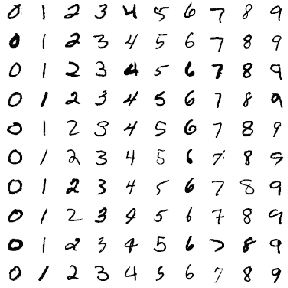

MNIST는 숫자 0부터 9까지의 이미지로 구성된 손글씨 데이터셋입니다. 이 데이터는 과거에 우체국에서 편지의 우편 번호를 인식하기 위해서 만들어진 훈련 데이터입니다. 총 60,000개의 훈련 데이터와 레이블, 총 10,000개의 테스트 데이터와 레이블로 구성되어져 있습니다. 레이블은 0부터 9까지 총 10개입니다. 이 예제는 머신 러닝을 처음 배울 때 접하게 되는 가장 기본적인 예제이기도 합니다.

MNIST 문제는 손글씨로 적힌 숫자 이미지가 들어오면, 그 이미지가 무슨 숫자인지 맞추는 문제입니다. 예를 들어 숫자 5의 이미지가 입력으로 들어오면 이게 숫자 5다! 라는 것을 맞춰야 합니다. 이 문제는 사람에게는 굉장히 간단하지만 기계에게는 그렇지가 않습니다.

우선 MNIST 문제를 더 자세히 보겠습니다. 각각의 이미지는 아래와 같이 28 픽셀 × 28 픽셀의 이미지입니다.

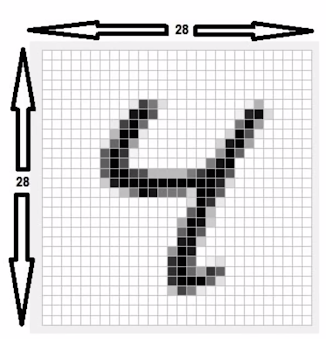

이 문제를 풀기 위해 여기서는 28 픽셀 × 28 픽셀 = 784 픽셀이므로, 각 이미지를 총 784의 원소를 가진 벡터로 만들어줄겁니다. 이렇게 되면 총 784개의 특성을 가진 샘플이 되는데, 이는 앞서 우리가 풀었던 그 어떤 문제들보다 특성이 굉장히 많은 샘플입니다.

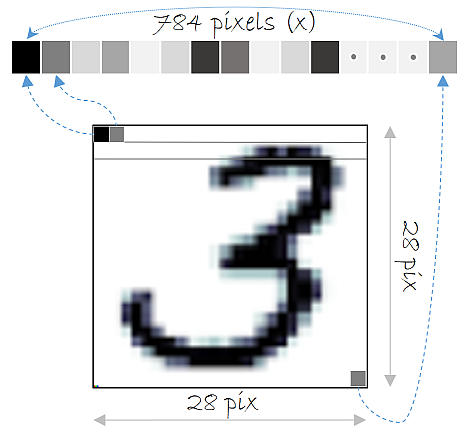

784차원의 벡터로 만드는 코드를 미리보기로 보면 아래와 같습니다.

In [3]:
# for X, Y in data_loader:
#   # 입력 이미지를 [batch_size × 784]의 크기로 reshape
#   # 레이블은 원-핫 인코딩
#   X = X.view(-1, 28*28)

위의 코드에서 X는 for문에서 호출될 때는 (배치 크기 × 1 × 28 × 28)의 크기를 가지지만, view를 통해서 (배치 크기 × 784)의 크기로 변환됩니다.

# 2. 토치비전(torchvision) 소개하기

---

본격적인 실습에 들어가기에 앞서 토치비전(torchvision)이라는 도구를 설명하겠습니다. torchvision은 유명한 데이터셋들, 이미 구현되어져 있는 유명한 모델들, 일반적인 이미지 전처리 도구들을 포함하고 있는 패키지입니다. 아래의 링크는 torchvision에 어떤 데이터셋들(datasets)과 모델들(models) 그리고 어떤 전처리 방법들(transforms)을 제공하고 있는지 보여줍니다.

링크 : https://pytorch.org/docs/stable/torchvision/index.html

+ **자연어 처리를 위해서는 토치텍스트(torchtext)라는 패키지가 있습니다.**

# 3. 분류기 구현을 위한 사전 설정

---

우선 필요한 도구들을 임포트합니다.

In [5]:
!pip install torchvision

  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/e7/45/419aa0b37254f1fd62b45bb63836066c5eb81e37d70940e0491e95167eed/torchvision-0.17.1-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ----- ---------------------------------- 0.2/1.2 MB 2.5 MB/s eta 0:00:01
   ----------------------- ---------------- 0.7/1.2 MB 7.2 MB/s eta 0:00:01
   ---------------------------------------  1.2/1.2 MB 8.2 MB/s eta 0:00:01
   ---------------------------------------- 1.2/1.2 MB 7.4 MB/s eta 0:00:00


In [6]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import random

In [7]:
USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cpu


구글의 Colab에서 '런타임 > 런타임 유형 변경 > 하드웨어 가속기 > GPU'를 선택하면 USE_CUDA의 값이 True가 되면서 '다음 기기로 학습합니다: cuda'라는 출력이 나옵니다. 즉, GPU로 연산하겠다는 의미입니다. 반면에 '하드웨어 가속기 > None'을 선택하면 USE_CUDA의 값이 False가 되면서 '다음 기기로 학습합니다: cpu'라는 출력이 나옵니다. 즉, CPU로 연산하겠다는 의미입니다.

위의 방법은 앞으로 자주 쓰이게되므로 기억해둡시다.

랜덤 시드를 고정합니다.

In [8]:
# for reproducibility
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

하이퍼파라미터를 변수로 둡니다.

In [9]:
# hyperparameters
training_epochs = 15
batch_size = 100

# 4. MNIST 분류기 구현하기

---

torchvision.datasets.dsets.MNIST를 사용하여 MNIST 데이터셋을 불러올 수 있습니다.

In [10]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

100%|███████████████████████████████████████████████████████████████████| 9912422/9912422 [00:01<00:00, 5170988.74it/s]


Extracting MNIST_data/MNIST\raw\train-images-idx3-ubyte.gz to MNIST_data/MNIST\raw



100%|████████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<?, ?it/s]


Extracting MNIST_data/MNIST\raw\train-labels-idx1-ubyte.gz to MNIST_data/MNIST\raw



100%|███████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 5432490.19it/s]


Extracting MNIST_data/MNIST\raw\t10k-images-idx3-ubyte.gz to MNIST_data/MNIST\raw



100%|██████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST\raw\t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST\raw



첫번째 인자 root는 MNIST 데이터를 다운로드 받을 경로입니다. 두번째 인자 train은 인자로 True를 주면, MNIST의 훈련 데이터를 리턴받으며 False를 주면 테스트 데이터를 리턴받습니다. 세번째 인자 transform은 현재 데이터를 파이토치 텐서로 변환해줍니다. 네번째 인자 download는 해당 경로에 MNIST 데이터가 없다면 다운로드 받겠다는 의미입니다.

이렇게 데이터를 다운로드했다면 앞서 미니 배치와 데이터로드 챕터에서 학습했던 데이터로더(DataLoader)를 사용합니다.

In [11]:
# dataset loader
data_loader = DataLoader(dataset=mnist_train,
                                          batch_size=batch_size, # 배치 크기는 100
                                          shuffle=True,
                                          drop_last=True)

이때 DataLoader에는 4개의 인자가 있습니다. 첫번째 인자인 dataset은 로드할 대상을 의미하며, 두번째 인자인 batch_size는 배치 크기, shuffle은 매 에포크마다 미니 배치를 셔플할 것인지의 여부, drop_last는 마지막 배치를 버릴 것인지를 의미합니다.

+ **drop_last를 하는 이유를 이해하기 위해서 1,000개의 데이터가 있다고 했을 때, 배치 크기가 128이라고 해봅시다. 1,000을 128로 나누면 총 7개가 나오고 나머지로 104개가 남습니다. 이때 104개를 마지막 배치로 한다고 하였을 때 128개를 충족하지 못하였으므로 104개를 그냥 버릴 수도 있습니다. 이때 마지막 배치를 버리려면 drop_last=True를 해주면 됩니다. 이는 다른 미니 배치보다 개수가 적은 마지막 배치를 경사 하강법에 사용하여 마지막 배치가 상대적으로 과대 평가되는 현상을 막아줍니다.**

이제 모델을 설계합니다. input_dim은 784이고, output_dim은 10입니다.

In [12]:
# MNIST data image of shape 28 * 28 = 784
linear = nn.Linear(784, 10, bias=True).to(device)

to() 함수는 연산을 어디서 수행할지를 정합니다. to() 함수는 모델의 매개변수를 지정한 장치의 메모리로 보냅니다. CPU를 사용할 경우에는 필요가 없지만, GPU를 사용하려면 to('cuda')를 해 줄 필요가 있습니다. 아무것도 지정하지 않은 경우에는 CPU 연산이라고 보면 됩니다.

bias는 편향 b를 사용할 것인지를 나타냅니다. 기본값은 True이므로 굳이 할 필요는 없지만 명시적으로 True를 해주었습니다.
이제 비용 함수와 옵티마이저를 정의합니다.

In [13]:
# 비용 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss().to(device) # 내부적으로 소프트맥스 함수를 포함하고 있음.
optimizer = torch.optim.SGD(linear.parameters(), lr=0.1)

+ **앞서 소프트맥스 회귀를 배울 때는 torch.nn.functional.cross_entropy()를 사용하였으나 여기서는 torch.nn.CrossEntropyLoss()을 사용하고 있습니다. 둘 다 파이토치에서 제공하는 크로스 엔트로피 함수로 둘 다 소프트맥스 함수를 포함하고 있습니다.**

In [14]:
for epoch in range(training_epochs): # 앞서 training_epochs의 값은 15로 지정함.
    avg_cost = 0
    total_batch = len(data_loader)

    for X, Y in data_loader:
        # 배치 크기가 100이므로 아래의 연산에서 X는 (100, 784)의 텐서가 된다.
        X = X.view(-1, 28 * 28).to(device)
        # 레이블은 원-핫 인코딩이 된 상태가 아니라 0 ~ 9의 정수.
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = linear(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

Epoch: 0001 cost = 0.535150588
Epoch: 0002 cost = 0.359577775
Epoch: 0003 cost = 0.331264257
Epoch: 0004 cost = 0.316404670
Epoch: 0005 cost = 0.307106972
Epoch: 0006 cost = 0.300456554
Epoch: 0007 cost = 0.294933408
Epoch: 0008 cost = 0.290956199
Epoch: 0009 cost = 0.287074119
Epoch: 0010 cost = 0.284515619
Epoch: 0011 cost = 0.281914055
Epoch: 0012 cost = 0.279526860
Epoch: 0013 cost = 0.277636588
Epoch: 0014 cost = 0.275874794
Epoch: 0015 cost = 0.274422795
Learning finished


Accuracy: 0.8883000016212463
Label:  8
Prediction:  3


C:\Anaconda3\Lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Anaconda3\Lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


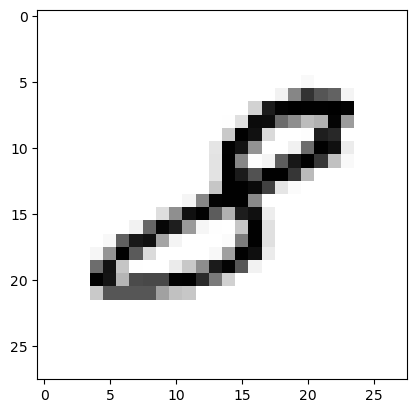

In [15]:
# 테스트 데이터를 사용하여 모델을 테스트한다.
with torch.no_grad(): # torch.no_grad()를 하면 gradient 계산을 수행하지 않는다.
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = linear(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # MNIST 테스트 데이터에서 무작위로 하나를 뽑아서 예측을 해본다
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = linear(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

    plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()